# Car Insurance Claim Prediction Dataset

The Car Insurance Claim Prediction dataset contains:
- information on policyholders
    - having the attributes like policy tenure, age of the car, age of the car owner, the population density of the city, make and model of the car, power, engine type, etc,...
- and the target variable
    - indicating whether the policyholder files a claim in the next 6 months or not

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kruskal, chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


#from xgboost import XGBClassifier

#from imblearn.over_sampling import SMOTE


In [3]:
df_train_pre = pd.read_csv("train.csv")
df_test_pre = pd.read_csv("test.csv")


In [4]:
df_train_pre.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [5]:
df_test_pre.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID58593,0.341732,0.00,0.586538,C3,4076,1,A,M1,CNG,...,No,No,No,No,Yes,No,No,No,Yes,0
1,ID58594,0.307241,0.13,0.442308,C8,8794,1,B2,M6,Petrol,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
2,ID58595,0.327924,0.12,0.451923,C8,8794,2,A,M3,Petrol,...,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2
3,ID58596,0.782654,0.01,0.461538,C5,34738,1,A,M1,CNG,...,No,No,No,No,Yes,No,No,No,Yes,0
4,ID58597,1.233404,0.02,0.634615,C5,34738,1,A,M1,CNG,...,No,No,No,No,Yes,No,No,No,Yes,0


## Data Preprocessing

The **bin2num()** function, takes in a categorical variable that is expected to contain binary responses represented as strings 'yes' or 'no' and systematically transforms these string values into numerical values, where 'yes' corresponds to 1 and 'no' corresponds to 0.

In [6]:
def bin2num(var):
    df_train_pre[var]= df_train_pre[var].map({"No": 0, "Yes": 1})
    df_test_pre[var] = df_test_pre[var].map({"No": 0, "Yes": 1})

In [7]:
binary_features = [
    "is_esc",
    "is_adjustable_steering",
    "is_tpms",
    "is_parking_sensors",
    "is_parking_camera",
    "is_front_fog_lights",
    "is_rear_window_wiper",
    "is_rear_window_washer",
    "is_rear_window_defogger",
    "is_brake_assist",
    "is_power_door_locks",
    "is_central_locking",
    "is_power_steering",
    "is_driver_seat_height_adjustable",
    "is_day_night_rear_view_mirror",
    "is_ecw",
    "is_speed_alert"
]

for feature in binary_features:
    bin2num(feature)

In [8]:
df_train_pre.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,0,0,0,1,0,0,0,1,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,0,0,0,1,0,0,0,1,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,0,0,0,1,0,0,0,1,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,1,1,1,1,1,1,1,1,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,0,1,1,1,0,1,1,1,2,0


In [9]:
categorical_vars = [
    "area_cluster",
    "make",
    "segment",
    "model",
    "fuel_type",
    "engine_type",
    "airbags",
    "is_esc",
    "is_adjustable_steering",
    "is_tpms",
    "is_parking_sensors",
    "is_parking_camera",
    "rear_brakes_type",
    "cylinder",
    "transmission_type",
    "gear_box",
    "steering_type",
    "is_front_fog_lights",
    "is_rear_window_wiper",
    "is_rear_window_washer",
    "is_rear_window_defogger",
    "is_brake_assist",
    "is_power_door_locks",
    "is_central_locking",
    "is_power_steering",
    "is_driver_seat_height_adjustable",
    "is_day_night_rear_view_mirror",
    "is_ecw",
    "is_speed_alert",
    "ncap_rating"
]

In [10]:
chi2_pvalue= []
for var in categorical_vars:
    contingency_table = pd.crosstab(df_train_pre[var], df_train_pre['is_claim'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_pvalue.append(p)
#chi2_pvalue.sort(key =lambda x:x[1])



In [11]:
print(chi2_pvalue)

[1.412557511595789e-11, 0.3516519554568966, 0.02738747673628079, 0.02949022219663932, 0.056145343695656484, 0.029490222196639326, 0.733046343840305, 0.47973082296004166, 0.0008041954126638532, 0.8804734284234931, 0.046026600078480424, 0.8464941782641769, 0.8804734284234931, 0.0012196212137077615, 0.8913806451098147, 0.8932484235563578, 0.05680882959490323, 0.004438415801344458, 0.5332800461995457, 0.5332800461995457, 0.5426511057939621, 0.008799083467312552, 0.11234220574905036, 0.11234220574905036, 0.6486012327453723, 0.010185701302166342, 0.055307437479256066, 0.11234220574905036, 0.09668666189604051, 0.8325265632423358]


In [12]:
print("Test  Chi-square p-values:")

for var, p in chi2_pvalue:
    print(f"{var}: {p}")

Test  Chi-square p-values:


TypeError: cannot unpack non-iterable numpy.float64 object

According to the $\chi^2$ test results, the **most significant variables for predicting "is_claim"** appear to be:

- area_cluster
- is_adjustable_steering
- cylinder
- is_front_fog_lights
- is_brake_assist
- is_driver_seat_height_adjustable
- max_torque
- max_power
- segment
- model
- engine_type
- is_parking_sensors
- is_day_night_rear_view_mirror
- fuel_type
- steering_type
- is_speed_alert


On the other hand, variables:


- is_power_door_locks
- is_central_locking
- is_ecw
- make
- is_esc
- is_rear_window_wiper
- is_rear_window_washer
- is_rear_window_defogger
- is_power_steering
- airbags
- ncap_rating
- is_parking_camera
- is_tpms
- rear_brakes_type
- transmission_type
- gear_box

have higher p-values, suggesting they may have less influence on the target variable.

PCA

In [13]:
numerical_vars = [
    "policy_tenure",
    "age_of_car",
    "age_of_policyholder",
    "population_density",
    # "max_torque",
    # "max_power",
    "displacement",
    "turning_radius",
    "length",
    "width",
    "height",
    "gross_weight"
]

In [14]:
scaler = StandardScaler()
numerical_data = df_train_pre[numerical_vars]
numerical_data_Standardized = scaler.fit_transform(numerical_data)
numerical_data_Standardized


array([[-0.23028345, -0.34244685,  1.42255728, ..., -1.40276762,
        -0.98384583, -0.94282842],
       [ 0.14818765, -0.87135928, -0.7683621 , ..., -1.40276762,
        -0.98384583, -0.94282842],
       [ 0.55502223, -0.87135928, -0.69011498, ..., -1.40276762,
        -0.98384583, -0.94282842],
       ...,
       [ 1.33048996, -0.34244685, -0.14238513, ..., -1.40276762,
        -0.98384583, -0.94282842],
       [ 1.50925096,  1.24429045,  0.7183332 , ...,  0.55997282,
        -0.29307842, -0.23668445],
       [-1.17545276, -0.87135928, -0.22063226, ...,  1.05065793,
         1.02565937,  1.57575173]])

In [15]:
pca = PCA()
pca.fit(numerical_data_Standardized)
components_df = pd.DataFrame(pca.components_,columns = numerical_vars)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.50740786, 0.11513607, 0.10038292, 0.08790109, 0.07671975,
       0.07299651, 0.0201212 , 0.01326207, 0.00490931, 0.00116322])

In [16]:
for i in range(len(components_df)):
    print(f"Component {i+1}")
    print(f"Explained Variance Ratio: {explained_variance_ratio[i]:.4f}")
    print("Loading Scores:")
    print(components_df.iloc[i].abs().sort_values(ascending=False))
    print("\n")

Component 1
Explained Variance Ratio: 0.5074
Loading Scores:
length                 0.435129
displacement           0.421910
turning_radius         0.409370
width                  0.402134
gross_weight           0.399924
height                 0.290308
age_of_car             0.209497
policy_tenure          0.110178
population_density     0.054969
age_of_policyholder    0.009573
Name: 0, dtype: float64


Component 2
Explained Variance Ratio: 0.1151
Loading Scores:
policy_tenure          0.667182
age_of_policyholder    0.648638
population_density     0.302775
height                 0.123809
age_of_car             0.117204
gross_weight           0.091644
turning_radius         0.046088
length                 0.037501
displacement           0.027328
width                  0.026884
Name: 1, dtype: float64


Component 3
Explained Variance Ratio: 0.1004
Loading Scores:
population_density     0.835321
age_of_policyholder    0.504129
age_of_car             0.173158
turning_radius         0.0683

The first 6 components explain the following percentage of the total variance:

-   Component 1: 50.74% (acc. 50.74%)
-   Component 2: 11.51% (acc. 62.25%)
-   Component 3: 10.04% (acc. 72.29%)
-   Component 4: 8.79% (acc. 81.08%)
-   Component 5: 7.67% (acc. 88.75%)
-   Component 6: 7.30% (acc. 96.05%)
The sum of these percentages is approximately 96.05%.

Principal variables are:

-   length
-   policy_tenure
-   population_density
-   height
-   age_of_car
-   age_of_policyholder
-   displacement
-   width
-   turning_radius

# Analysis of Variance (ANOVA)

In [17]:
continuous_vars =df_train_pre.select_dtypes(include =["float64", "int64"]).columns.tolist()
continuous_pvalues = {}

for var in continuous_vars:
    model = ols(f"{var}~ C(is_claim)", data=df_train_pre).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA for variable:", var)
    print(anova_table)
    print("\n")
    p_value = anova_table.loc["C(is_claim)","PR(>F)"]
    continuous_pvalues[var] = p_value


ANOVA for variable: policy_tenure
                  sum_sq       df           F        PR(>F)
C(is_claim)    62.320771      1.0  365.593096  3.018116e-81
Residual     9987.535419  58590.0         NaN           NaN


ANOVA for variable: age_of_car
                 sum_sq       df          F        PR(>F)
C(is_claim)    0.149607      1.0  46.537984  9.072911e-12
Residual     188.351229  58590.0        NaN           NaN


ANOVA for variable: age_of_policyholder
                 sum_sq       df          F        PR(>F)
C(is_claim)    0.445348      1.0  29.505774  5.597168e-08
Residual     884.333865  58590.0        NaN           NaN


ANOVA for variable: population_density
                   sum_sq       df          F    PR(>F)
C(is_claim)  5.795189e+09      1.0  18.586944  0.000016
Residual     1.826767e+13  58590.0        NaN       NaN


ANOVA for variable: make
                   sum_sq       df         F    PR(>F)
C(is_claim)      0.015736      1.0  0.012172  0.912149
Residual     7574

In [18]:
print("Continuous Variables ANOVA p-values:")
for var, p_value in sorted(continuous_pvalues.items(), key=lambda x: x[1]):
    print(f"{var}: {p_value:.4f}")

Continuous Variables ANOVA p-values:
is_claim: 0.0000
policy_tenure: 0.0000
age_of_car: 0.0000
age_of_policyholder: 0.0000
population_density: 0.0000
is_adjustable_steering: 0.0008
cylinder: 0.0011
is_front_fog_lights: 0.0042
is_brake_assist: 0.0084
is_driver_seat_height_adjustable: 0.0097
width: 0.0161
is_parking_sensors: 0.0416
is_day_night_rear_view_mirror: 0.0531
displacement: 0.0631
is_speed_alert: 0.0769
is_power_door_locks: 0.1081
is_central_locking: 0.1081
is_ecw: 0.1081
length: 0.1159
gross_weight: 0.3459
ncap_rating: 0.3577
is_esc: 0.4685
airbags: 0.4997
turning_radius: 0.5096
is_rear_window_wiper: 0.5211
is_rear_window_washer: 0.5211
is_rear_window_defogger: 0.5310
is_power_steering: 0.6065
height: 0.6243
is_parking_camera: 0.8330
is_tpms: 0.8649
gear_box: 0.8778
make: 0.9121


**Interpretation of results:**

- ANOVA Table: The output you see after running the code provides a statistical test of whether the group means of the continuous variable are equal across the different levels of the categorical variable (is_claim). If is_claim has only two levels, this is essentially a **t-test**.
- PR(>F) (p-value): This column indicates the probability of observing the calculated F-statistic or a more extreme value given that the null hypothesis is true (in this case, the null hypothesis is that there are no differences between the group means). A p-value less than a chosen significance threshold (commonly 0.05) would lead to the rejection of the null hypothesis, suggesting that there is a statistically significant effect of is_claim on the continuous variable.

Kruskal-Wallis H Test

CATEGORICAL fREATURES

In [19]:
categorical_vars = df_train_pre.select_dtypes(include =["object"]).columns.tolist()
categorical_pvalues = {}

for var in categorical_vars:
    groups =[]
    for group_name, group_data in df_train_pre.groupby("is_claim"):
        groups.append(group_data[var])
    print("Kruskal-Wallis H Test: ", var)
    print(kruskal(*groups))
    print("\n")
    h_value,p_value =kruskal(*groups)
    categorical_pvalues[var] = p_value

Kruskal-Wallis H Test:  policy_id


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=0.5133773524721619, pvalue=0.47368046966695965)


Kruskal-Wallis H Test:  area_cluster


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=2.592769741144916, pvalue=0.1073524597258797)


Kruskal-Wallis H Test:  segment


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=2.7183569189046066, pvalue=0.0992000830763159)


Kruskal-Wallis H Test:  model


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=2.612916963461148, pvalue=0.1059966303582979)


Kruskal-Wallis H Test:  fuel_type


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=5.40873484166179, pvalue=0.02003623219310955)


Kruskal-Wallis H Test:  max_torque


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=13.168011133910934, pvalue=0.0002847688200337916)


Kruskal-Wallis H Test:  max_power


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=3.236723797737833, pvalue=0.07200449052981103)


Kruskal-Wallis H Test:  engine_type


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=0.04041374296372383, pvalue=0.8406737898127361)


Kruskal-Wallis H Test:  rear_brakes_type


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=0.028952589898221956, pvalue=0.8648885503138044)


Kruskal-Wallis H Test:  transmission_type


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=0.023800402490416917, pvalue=0.8773938619051139)


Kruskal-Wallis H Test:  steering_type


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=5.3437301003238655, pvalue=0.020796926637325387)




In [20]:
print("Categprical Variables H test p-values:")
for var, p_value in sorted(categorical_pvalues.items(), key=lambda x: x[1]):
    print(f"{var}: {p_value:.4f}")

Categprical Variables H test p-values:
max_torque: 0.0003
fuel_type: 0.0200
steering_type: 0.0208
max_power: 0.0720
segment: 0.0992
model: 0.1060
area_cluster: 0.1074
policy_id: 0.4737
engine_type: 0.8407
rear_brakes_type: 0.8649
transmission_type: 0.8774


**Interpretation of results:**

- The test statistic (H-statistic) is a measure of the degree to which the group medians differ. A higher value typically indicates greater differences between the group medians.
- The p-value tells you the probability of observing the computed statistic or one more extreme if the null hypothesis is true. In the context of the Kruskal-Wallis H test, the null hypothesis is that the population median of all groups is equal.

Following the above results, and taking $\alpha = 0.10$ (although 0.05 is a more common value), features to consider for the future model are:

**Numerical Features:**
- is_claim: 0.0000
- policy_tenure: 0.0000
- age_of_car: 0.0000
- age_of_policyholder: 0.0000
- population_density: 0.0000
- is_adjustable_steering: 0.0008
- cylinder: 0.0011
- is_front_fog_lights: 0.0042
- is_brake_assist: 0.0084
- is_driver_seat_height_adjustable: 0.0097
- width: 0.0161
- is_parking_sensors: 0.0416
- is_day_night_rear_view_mirror: 0.0531
- displacement: 0.0631
- is_speed_alert: 0.0769

**Categorical Features:**
- max_torque: 0.0003
- fuel_type: 0.0200
- steering_type: 0.0208
- max_power: 0.0720
- segment: 0.0992

EDA AND DATA PROCESSING

In [21]:
model_vars = [
    "is_claim",
    "policy_tenure",
    "age_of_car",
    "age_of_policyholder",
    "population_density",
    "is_adjustable_steering",
    "cylinder",
    "is_front_fog_lights",
    "is_brake_assist",
    "is_driver_seat_height_adjustable",
    "width",
    "is_parking_sensors",
    "is_day_night_rear_view_mirror",
    "displacement",
    "is_speed_alert",
    "max_torque",
    "fuel_type",
    "steering_type",
    "max_power",
    "segment"
]

In [37]:
model_vars1 = [
    
    "policy_tenure",
    "age_of_car",
    "age_of_policyholder",
    "population_density",
    "is_adjustable_steering",
    "cylinder",
    "is_front_fog_lights",
    "is_brake_assist",
    "is_driver_seat_height_adjustable",
    "width",
    "is_parking_sensors",
    "is_day_night_rear_view_mirror",
    "displacement",
    "is_speed_alert",
    "max_torque",
    "fuel_type",
    "steering_type",
    "max_power",
    "segment"
]

In [38]:
test_df = df_test_pre[model_vars1].copy()

In [31]:
model_vars_test = model_vars.copy()
model_vars_test.remove("is_claim")
trian_df = df_train_pre[model_vars].copy()
test_df = df_test_pre[model_vars].copy()

KeyError: "['is_claim'] not in index"

The **print_unique()** function takes in a categorical variable and prints a list of the unique values the variable takes.

In [28]:
def print_unique(var):
    unique = trian_df[var].unique()
    print(unique)
    return unique


The **count_occ()** function takes in a categorical variable and prints the amount of times each unique value of the variable appears.

In [ ]:
def count_occ(column_name, df=train_df):
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} not found in the dataframe")
    variable_counts= df[column_name].value_counts().to_dict()
    print(variable_counts)
    return variable_counts

The **applyOHE*()** function takes in a categorical variable and applies OneHot Encoding.

In [ ]:
def applyOHE(df, column):
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_trasform(df[[column]])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out([column]))
    df = pd.concat([df.drop(columns=[column]), encoded_df], axis=1)
    return df

## policy_tenure

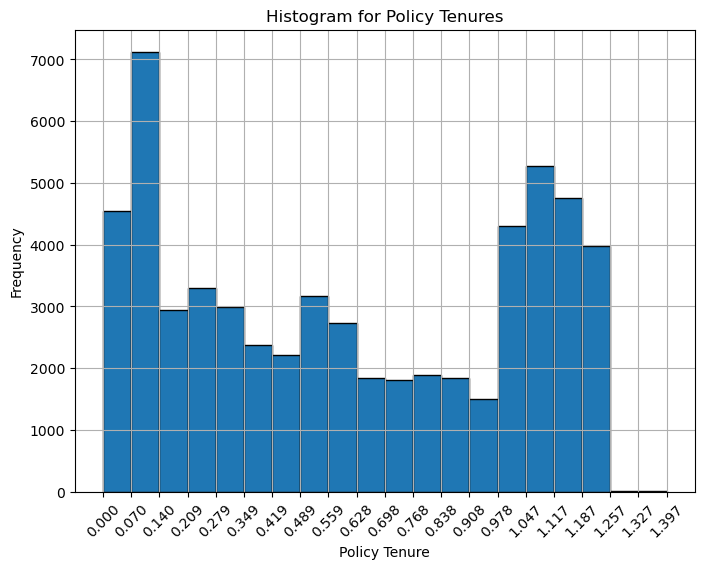

In [35]:
max_value = trian_df["policy_tenure"].max()
num_bins= int(np.ceil(max_value/0.07))
bin_edges = np.linspace(0, max_value,num_bins +1)

plt.figure(figsize=(8,6))
plt.hist(trian_df["policy_tenure"], bins=bin_edges, edgecolor = "black")
plt.title("Histogram for Policy Tenures")
plt.xlabel("Policy Tenure")
plt.ylabel("Frequency")
plt.xticks(bin_edges)
plt.xticks(rotation =45)
plt.grid(True)
plt.show()

In [39]:
max_value=trian_df["policy_tenure"].max()
min_value= trian_df["policy_tenure"].min()

trian_df["policy_tenure_normalized"]=(trian_df["policy_tenure"] - min_value)/(max_value-min_value)
test_df["policy_tenure_normalized"]=(test_df["policy_tenure"] - min_value)/(max_value-min_value)

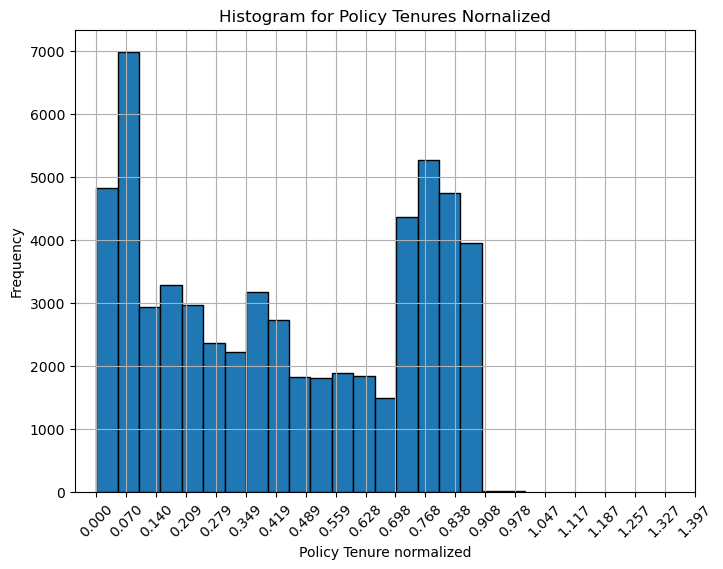

In [40]:
num_bins = 20

plt.figure(figsize=(8,6))
plt.hist(trian_df["policy_tenure_normalized"], bins=num_bins, edgecolor="black")
plt.title("Histogram for Policy Tenures Nornalized")
plt.xlabel("Policy Tenure normalized")
plt.ylabel("Frequency")
plt.xticks(bin_edges)
plt.xticks(rotation =45)
plt.grid(True)
plt.show()